In [244]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [245]:
data = pd.read_csv('data/MBTA_Monthly_Ridership_By_Mode.csv')

data["service_date"] = pd.to_datetime(data["service_date"])
data.set_index("service_date", inplace=True)
# data.index = pd.to_datetime(data["service_date"])
data = data.dropna(
    subset=[
        "total_monthly_ridership",
        "average_monthly_ridership",
        "total_monthly_weekday_ridership",
        "average_monthly_weekday_ridersh",
    ]
)
data = data[(data["mode"] == "Rail") & (data["route_or_line"] == "Red Line")]
data["total_monthly_ridership"] = data["total_monthly_ridership"].astype(int)
data["average_monthly_ridership"] = data["average_monthly_ridership"].astype(int)
data["average_monthly_weekday_ridersh"] = data["average_monthly_weekday_ridersh"].astype(int)
data["total_monthly_weekday_ridership"] = data[
    "total_monthly_weekday_ridership"
].astype(int)


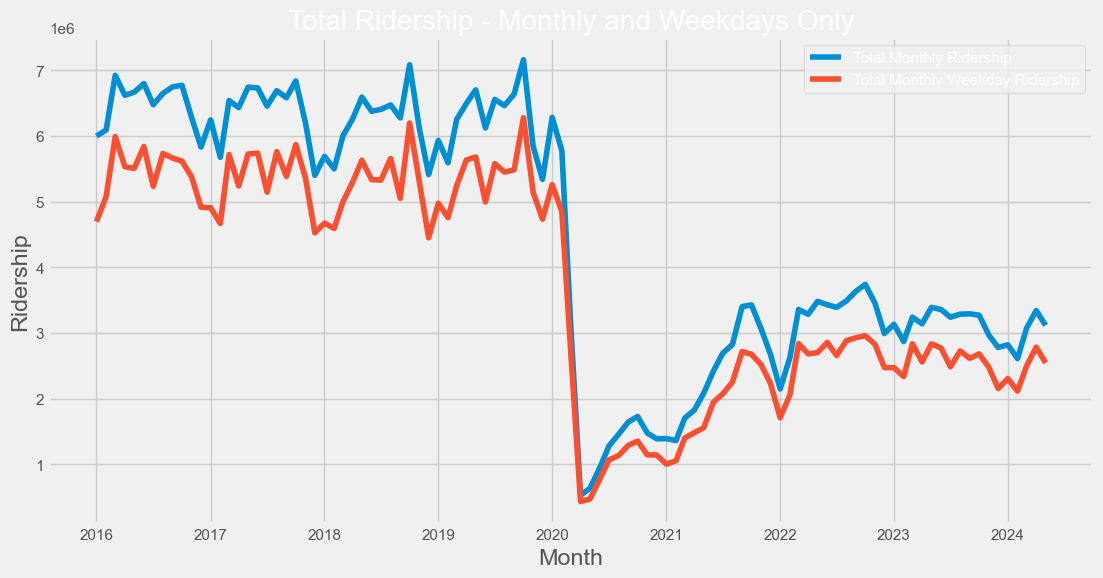

In [246]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=data,
    x=data.index,
    y="total_monthly_ridership",
    label="Total Monthly Ridership",
)
sns.lineplot(
    data=data,
    x=data.index,
    y="total_monthly_weekday_ridership",
    label="Total Monthly Weekday Ridership",
)

plt.title("Total Ridership - Monthly and Weekdays Only")
plt.xlabel('Month')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.show()

Filtered DataFrame with headways:
         trip_id stop_id        arrival_time departure_time    headway
606    63145143   70061 2024-07-06 23:19:20     1970-01-01   6.683333
7352   63145283   70061 2024-07-06 23:29:32     1970-01-01  10.200000
7787   63145161   70061 2024-07-06 23:34:12     1970-01-01   4.666667
5842   63145284   70061 2024-07-06 23:41:12     1970-01-01   7.000000
15904  63145179   70061 2024-07-06 23:53:07     1970-01-01  11.916667
12622  63145285   70061 2024-07-07 00:03:04     1970-01-01   9.950000
11791  63145197   70061 2024-07-07 00:12:42     1970-01-01   9.633333
15734  63145286   70061 2024-07-07 00:21:30     1970-01-01   8.800000
968    63145215   70061 2024-07-07 00:30:42     1970-01-01   9.200000
4019   63145287   70061 2024-07-07 00:39:30     1970-01-01   8.800000
816    63145219   70061 2024-07-07 00:51:42     1970-01-01  12.200000
15193  63145288   70061 2024-07-07 00:58:30     1970-01-01   6.800000
10935  63145289   70061 2024-07-07 01:17:30     1970-01

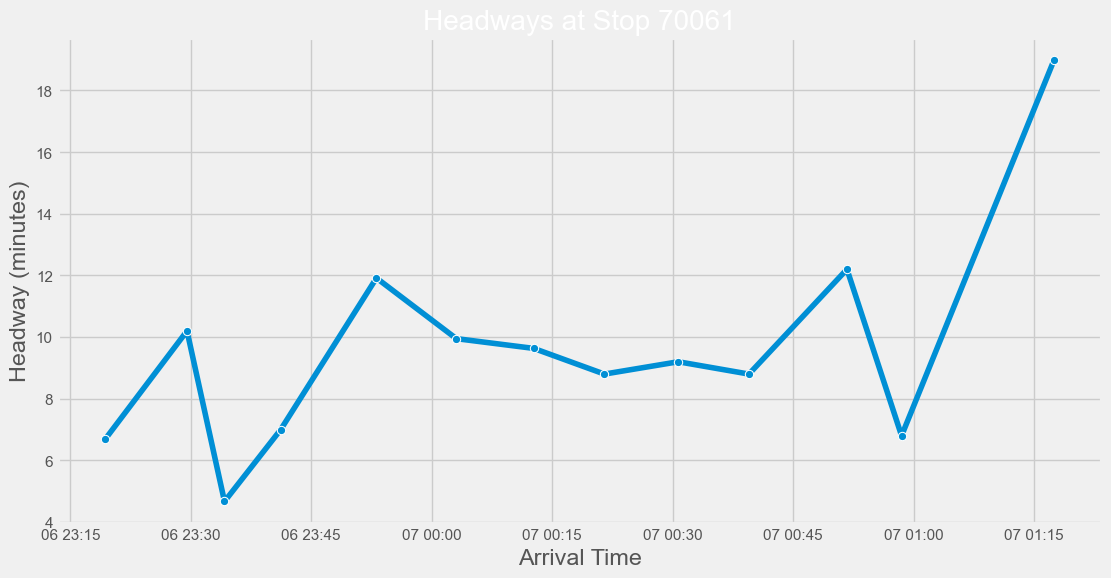

In [250]:
import requests
from google.transit import gtfs_realtime_pb2
from datetime import datetime, timedelta

feed_url = "https://cdn.mbta.com/realtime/TripUpdates.pb"
response = requests.get(feed_url)
feed = gtfs_realtime_pb2.FeedMessage()
feed.ParseFromString(response.content)

data = []
for entity in feed.entity:
    if entity.HasField('trip_update'):
        for stop_time_update in entity.trip_update.stop_time_update:
            data.append({
                'trip_id': entity.trip_update.trip.trip_id,
                'stop_id': stop_time_update.stop_id,
                'arrival_time': stop_time_update.arrival.time,
                'departure_time': stop_time_update.departure.time
            })

df = pd.DataFrame(data)

df['arrival_time'] = pd.to_datetime(df['arrival_time'], unit='s', errors='coerce')
df['departure_time'] = pd.to_datetime(df['departure_time'], unit='s', errors='coerce')

df.dropna(subset=['arrival_time', 'departure_time'], inplace=True)

current_time = datetime.now()
min_time = current_time - timedelta(weeks=1)
max_time = current_time

stop_id_to_filter = '70061'
df_filtered = df[
    (df["arrival_time"] >= min_time)
    # & (df["arrival_time"] <= max_time)
    & (df["stop_id"] == stop_id_to_filter)
]

df_filtered = df_filtered.sort_values(by='arrival_time', inplace=False)

df_filtered['headway'] = df_filtered['arrival_time'].diff().dt.total_seconds() / 60  # headway in minutes

df_filtered = df_filtered.dropna(subset=['headway'], inplace=False)

print("Filtered DataFrame with headways:\n", df_filtered)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_filtered, x='arrival_time', y='headway', marker='o')

plt.title("Headways at Stop 70061")
plt.xlabel('Arrival Time')
plt.ylabel('Headway (minutes)')
plt.grid(True)
plt.show()


In [248]:
routes = pd.read_csv("data/MBTA_GTFS/routes.txt")
print(routes.head())

   route_id  agency_id route_short_name   route_long_name     route_desc  \
0       Red          1              NaN          Red Line  Rapid Transit   
1  Mattapan          1              NaN  Mattapan Trolley  Rapid Transit   
2    Orange          1              NaN       Orange Line  Rapid Transit   
3   Green-B          1                B      Green Line B  Rapid Transit   
4   Green-C          1                C      Green Line C  Rapid Transit   

   route_type                                route_url route_color  \
0           1       https://www.mbta.com/schedules/Red      DA291C   
1           0  https://www.mbta.com/schedules/Mattapan      DA291C   
2           1    https://www.mbta.com/schedules/Orange      ED8B00   
3           0   https://www.mbta.com/schedules/Green-B      00843D   
4           0   https://www.mbta.com/schedules/Green-C      00843D   

  route_text_color  route_sort_order route_fare_class        line_id  \
0           FFFFFF             10010    Rapid Tran